<h1  style="color:white; background-color: #154360; padding:30px;"> 
Analyse du papier <em>Automated market maker inventory management with deep reinforcement learning</em> </h1>

Dans ce notebook je présente le papier [Automated market maker inventory management with deep reinforcement learning](https://www.researchgate.net/publication/363302274_Deep_Reinforcement_Learning_Approach_for_Trading_Automation_in_The_Stock_Market), et mes résultats numériques.

<h3  style="color:white; background-color: #154360; padding:15px;"> 
I- Définitions </em> </h3>

*Orderbook (OB)* : Chaque actif est coté par des ordres de vente et d'achat sur le marché (émis par des personnes physiques, institutions, banques, etc.). On distingue deux types d'ordres :  
- **Market order** : ordre exécuté au meilleur prix disponible sur le marché.
- **Limit order** : ordre qui ne s'exécute que si le prix atteint un certain seuil.
    
On appelle **bid** le prix d'achat le plus haut , **ask** le prix de vente le plus bas, **spread** la différence entre le ask et le bid
et **mid price** la moyenne de bid et ask.

L'orderbook regroupe l'ensemble des prix quotés par un actif sur le marché.


*Limit Orderbook (LOB)* : Le LOB n'est constituté que de limit orders.

*Market Maker (MM)* : A chaque instant il quote des prix d'achats et de vente pour assurer la liquidité du marché. Lorsque ces ordres sont exécutés, le market maker accumule les quantités d'actifs obtenues dans un inventaire. Ses objectifs sont : 
- maximiser ses profits obtenues avec ses ordres d'achats et de vente.
- minimizer le risque lié à détenir un inventaire (risque de marché, risque de liquidité, volatilité de l'actif, etc..)

Dans toute la suite on note $\mathbb{T} = \{ t_0, \ldots, t_n \}$ l'espace temps où les ordres ont lieu, et on considère un espace filtré 
$(\Omega, \mathcal{F}, \mathbb{F} = (\mathcal{F})_{t \in \mathbb{T}}, \mathbb{P})$ où sont définis toutes les variables aléatoires (mid price, spread, quantité d'actifs échangés, etc ... ). Introduisons comme dans [Reinforcement Learning for Market Making in a Multi-Agent Dealer Market](https://arxiv.org/pdf/1911.05892) des notations qui seront utiles pour la suite.
- $(cash)_{t \in \mathbb{T} }$
- $(P_t)_{t \in \mathbb{T}}$ est le mid price, processus stochastique adapté à $\mathbb{F}$.
- $((S_p)_t)_{t \in \mathbb{T}}$ est le spread, adapté à $\mathbb{F}$.
- $(z_t)_{t \in \mathbb{T}}$ est la quantité d'actifs dans l'inventaire, processus prévisible.
- $(q_t)_{t \in \mathbb{T}}$ est la quantité d'actifs reçues par le MM, $q_t^a$ la quantité achetés et $q_t^s$ la quantité vendus. 
- $((S_p^{b})_t)_{t \in \mathbb{T}}$, $((S_p^{s})_t)_{t \in \mathbb{T}}$ respectivement les spread d'achat et de vente côtés par le MM, les prix côtées par le MM sont donc : 
\begin{equation*}
   \forall t \in \mathbb{T}, \quad  P_t^b = P_t - (S_p^b)_t
\end{equation*}

\begin{equation*}
   \forall t \in \mathbb{T}, \quad  P_t^s = P_t + (S_p^s)_t
\end{equation*}

Introduisons aussi les métriques qu'on utilisera dans la suite pour évaluer les performances du MM : 
- **PNL** : (ensemble des profits ou pertes réalisés par le MM à un instant donné)
\begin{equation*}
\forall t  \in \mathbb{T}, \quad 
\text{PNL}_t = \sum_{i=1}^{t} q_{t_i} (P_{t_i}^{s} - P_{t_i}^{b}) + z_t P_t
\end{equation*}
- **Mark to Market (MtM)** : évalutation du cash au prix actuel du marché
\begin{equation*}
\forall t  \in \mathbb{T}, \quad 
\text{MtM}_t = \text{cash}_t + z_t P_t
\end{equation*}






**Objectifs** : trouver les spreads qui maximizent le profit / minimizer le risque d'inventaire.

<h3  style="color:white; background-color: #154360; padding:15px;"> 
II- Approche par Renforcement (Profond) </em> </h3>

**Motivations** : 
- model-free : Les algorithmes de renforcement (value-based, policy-based, actor-critic) sont par nature model-free dans le sens où ils nécessitent peu d'informations sur l'environnement et peu d'hypothèses sur sur la variable d'état.
- utilisation de MLP ( Multi-layer Perceptron) : approximateurs universels et ne sont pas atteint par la malédiction de la dimension.
- reward non instantanés : ....

**Modélisation du problème dans le formalisme du renforcement**, les auteurs modélisent le probème comme suit : 
<!-- - TODO voir espace des observations  -->
- $\mathcal{S} \subset \mathbb{R}^{7}$ (espace des états), on note $(S_t)_{t \in \mathbb{T}}$ la variable d'état à valeur dans $\mathcal{S}$:
\begin{equation*}
    S_t = \left( q_{t-1}^b,q_{t-1}^s,z_t, z_{t-1}, P_t - P_{t-1}, (S_p)_t,(S_p)_{t-1}   \right)
\end{equation*}
- $\mathcal{A} \in \text{Ticks}_a \times \text{Ticks}_b \times \text{Ticks}_{\text{hedge}}$ (espace des actions), avec $ \text{Ticks}_a$ et $\text{Ticks}_b$  des ensembles discrets représentant les ticks que le MM peut streamer à l'achat et à la vente, ie : 
\begin{equation*}
(S_p^{b})_t = (S_p)_t( 1 + \text{tick} ), \quad \text{tick} \in \text{Ticks}_b 
\end{equation*}

\begin{equation*}
(S_p^{s})_t = (S_p)_t( 1 + \text{tick} ), \quad \text{tick} \in \text{Ticks}_s 
\end{equation*}

et $\text{Ticks}_{\text{hedge}}$ sont les proportions d'inventaire que le MM peut instanément liquider sur le marché en émettant un market order.
- La récompense à un instant $t \in \mathbb{T}$ est : 

\begin{equation*}

        R_t = \underbrace{\sum_{i= 0}^{t} \left(q_{t_i}^a (S_p^a)_t + q_{t_i}^b (S_p^b)_t\right)}_{\text{spread PNL}}
            + \underbrace{z_t (P_{t} - P_{t-1})}_{\text{inventory PNL}}
            - \underbrace{z_t  (S_p)_t  \text{tick}_{\text{hedge}}}_{\text{hedging cost}}
            - \underbrace{Pn_t}_{\text{inventory penalty}}
\end{equation*}

où $Pn_t = AIIF * \min\left( |R_t|, |R_t * \frac{\overline{inv_t}}{\overline{thr_t}}| \right)$
$$
\begin{align*}
\text{avec:} \notag \\
thr_t &= DITF * \left|\frac{\text{cash}_{t_i}}{\frac{1}{n} \sum_{i=t-n}^{t} P_{t_i}}\right|  \\
\overline{thr_t} &= \frac{1}{n} \sum_{i=t-n}^{t} thr_{t_i}  \\
\overline{inv_t} &= \frac{1}{n} \sum_{i=t-n}^{t} z_{t_i}
\end{align*}
$$

et AIIF (Alfa Inventory Impact Factor) et DITF (Dynamic Inventory Threshold Factor) sont des coefficients de pénalization introduit par les auteurs. Expliquons les termes apparaissant dans l'inventory penalty.    

On applique la pénalité de gauche si  
$$
\overline{inv_t} \geq  DITF \left|\frac{\text{cash}_{t_i}}{\frac{1}{n} \sum_{i=t-n}^{t} P_{t_i}}\right| 
$$

ie si le ratio cash / inventaire dépasse un certain seuil fixé par DITF (par exemple si $DITF = 0.5$ alors le seuil à partir du duquel on applique la pénalité complète est 50% / 50%). En dessous de ce seuil à on va pénaliser le MM de facon linéaire en fonction du ratio cash / inventaire, si le ratio augmente on pénalisera plus et inversement. DITF représente donc le seuil acceptable du ratio cash / inventaire par le MM. AIIF quant à lui représente l'aversion au risque du MM.

**Question** : est ce le triplet $(\mathcal{S}, \mathcal{A}, R)$ définit-il bien un MDP?

<h3  style="color:white; background-color: #154360; padding:15px;"> 
III- Implémentation de l'orderbook </em> </h3>

Implémentation naive de l'orderbook, le midprice est un mouvement brownien géométrique (drift nul) et le spread une loi normale avec les mêmes incréments gaussiens : 

\begin{equation*}
    P_t = P_0 e^{-\frac{\sigma^2}{2}t + \sigma \sqrt{t} Z}, \quad Z \sim \mathcal{N}(0,1)
\end{equation*} 

\begin{equation*}
    (S_p)_t = \text{spread} + Z
\end{equation*}

avec $\text{spread}$ et $P_0$ les valeurs initiales du spread. On modélise un orderbook peuplé de :
- noisy agents qui stream des ordres de direction, ticks et quantité aléatoires.
- market makers qui stream des ordres d'achat et de vente à quantité fixée.

### Imports 

In [1]:
from naive_order_book.market import Market
from naive_order_book.orderbook import OrderBook
from naive_order_book.agents.market_makers.random_market_maker import RandomMarketMaker
from naive_order_book.agents.market_makers.dqn_market_maker import DQNMarketMaker
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from tqdm import tqdm

### Check ( No Training)

In [2]:
interval = float(15 / (24 * 60))  # 15min
num_trades = 24  # 2h trades
vol = 0.2
initial_cash = 10000
amount_to_trade = 50
price_ticks = np.arange(1, -1, step=-0.2)
quantities = [40, 45, 50, 55, 60]
random_mm = RandomMarketMaker(initial_cash,amount_to_trade)

In [3]:
list_weights = [40, 20]
activation_function = nn.ReLU()
gamma = 0.6
epsilon = 0.01
epsilon_decay = 0.001
epsilon_max = 0.99
learning_rate = 1e-2
batch_size = 50
replay_memory_init = 80
replay_memory_capacity = 100000
N_update = 15
dqn_mm = DQNMarketMaker(
    initial_cash,
    amount_to_trade,
    epsilon,
    epsilon_decay,
    epsilon_max,
    gamma,
    replay_memory_init,
    replay_memory_capacity,
    N_update,
    learning_rate,
    batch_size,
    activation_function,
    list_weights,
    input_dim = 7,
    output_dim=605
)

In [4]:
sim = Market(
    interval,
    num_trades,
    vol,
    random_mm,
    dqn_mm,
    num_noise_agents=100,
)

In [5]:
_, _, _, _, books, _ = sim.simulate(
    100, 3, price_ticks, price_ticks, quantities, save_books=True
)

In [6]:
def plot_order_book(orderbook : OrderBook, title : str):
    """_summary_

    Args:
        orderbook (OrderBook): _description_
        title (str): _description_
    """
    plt.figure(figsize=(8,7))
    bid_prices = sorted(orderbook.bids.keys(), reverse=True)
    ask_prices = sorted(orderbook.asks.keys())

    bid_quantities = []
    ask_quantities = []

    mm_bid_quantities = []
    mm_ask_quantities = []

    for price in bid_prices:
        normal_bid_qty = 0
        mm_bid_qty = 0
        for order in orderbook.bids[price]:
            if order.agent_id == "random_agent":
                mm_bid_qty += order.quantity
            else:
                normal_bid_qty += order.quantity
        bid_quantities.append(
            -normal_bid_qty
        )  
        mm_bid_quantities.append(
            -mm_bid_qty
        )  

    for price in ask_prices:
        normal_ask_qty = 0
        mm_ask_qty = 0
        for order in orderbook.asks[price]:
            if order.agent_id == "random_agent":
                mm_ask_qty += order.quantity
            else:
                normal_ask_qty += order.quantity
        ask_quantities.append(normal_ask_qty)  
        mm_ask_quantities.append(mm_ask_qty)  

    plt.bar(bid_prices, bid_quantities, color="green")

    plt.bar(bid_prices, mm_bid_quantities, color="blue", label="Random MM Buy Orders")

    plt.bar(ask_prices, ask_quantities, color="red")

    plt.bar(ask_prices, mm_ask_quantities, color="cyan", label="Random MM Sell Orders")

    mid_price = (bid_prices[0] + ask_prices[0]) / 2
    plt.axvline(x=mid_price, color="blue", linestyle="--", label="Mid Price")

    # Labels et titre
    plt.xlabel("Price")
    plt.ylabel("Quantity")
    plt.title("Order book at time " + title)
    plt.legend()

    # Modifier les étiquettes de l'axe des ordonnées en valeurs absolues
    y_ticks = plt.gca().get_yticks()  # Obtenir les valeurs actuelles des ticks
    plt.gca().set_yticklabels(
        [f"{int(abs(tick))}" for tick in y_ticks]
    )  # Mettre en valeur absolue

    # Afficher le graphique
    plt.show()

C:\Users\amaur\AppData\Local\Temp\ipykernel_14216\2707410631.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


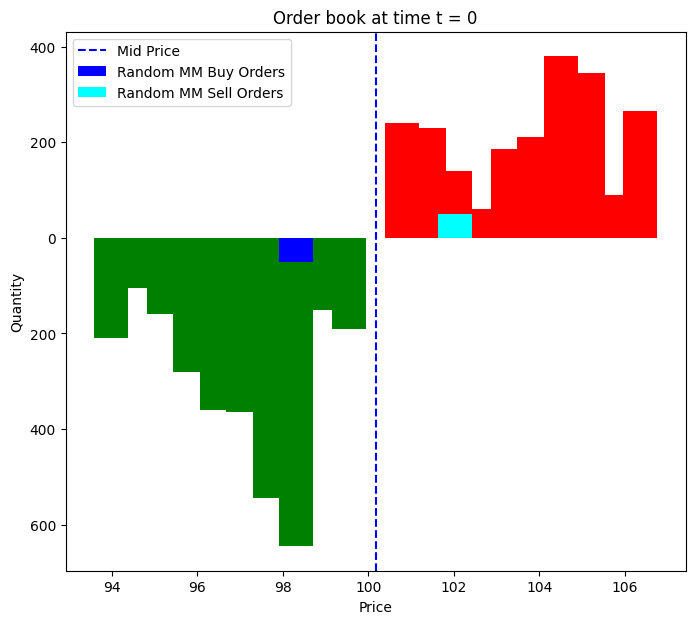

In [7]:
plot_order_book(books[0],"t = 1")

C:\Users\amaur\AppData\Local\Temp\ipykernel_14216\2707410631.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(


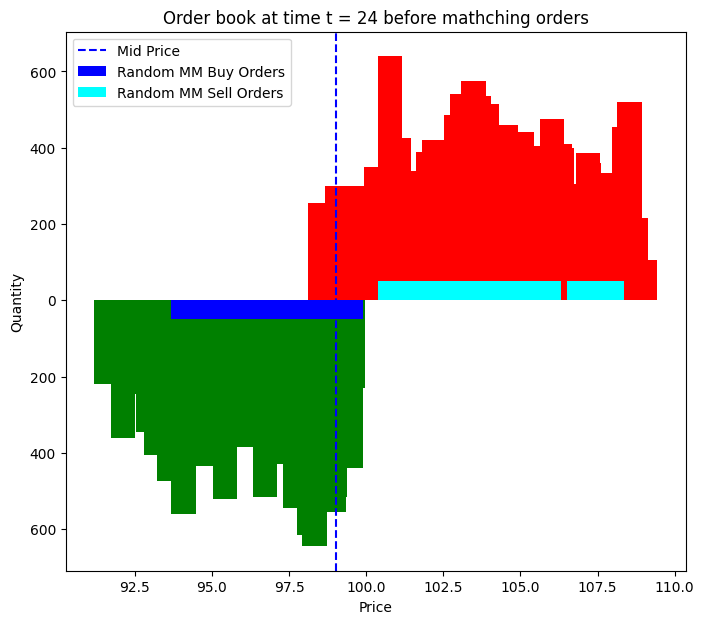

In [8]:
plot_order_book(books[-1],"t = 24 before mathching orders")

### Training the DQN Market Maker

In [10]:
dqn_mm = DQNMarketMaker(
    initial_cash,
    amount_to_trade,
    epsilon,
    epsilon_decay,
    epsilon_max,
    gamma,
    replay_memory_init,
    replay_memory_capacity,
    N_update,
    learning_rate,
    batch_size,
    activation_function,
    list_weights,
    input_dim = 7,
    output_dim=605
)

random_mm = RandomMarketMaker(initial_cash,amount_to_trade)

sim = Market(
    interval,
    num_trades,
    vol,
    random_mm,
    dqn_mm,
    num_noise_agents=100,
)

In [11]:
epochs = 200
spot = 100
spread = 3
losses = np.zeros(epochs)
epsilons = np.zeros(epochs)
rewards = np.zeros(epochs)
for epoch in tqdm(range(epochs)):
    epsilons[epoch] = dqn_mm.epsilon
    _, _, _, _, _, reward = sim.simulate(
        spot, spread, price_ticks, price_ticks, quantities, save_books=True
    )
    losses[epoch] = dqn_mm.train_online_network()
    rewards[epoch] = reward
    if epoch % N_update == 0:
        dqn_mm.update_target_network()

100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


C:\Users\amaur\AppData\Local\Temp\ipykernel_7016\1516601315.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


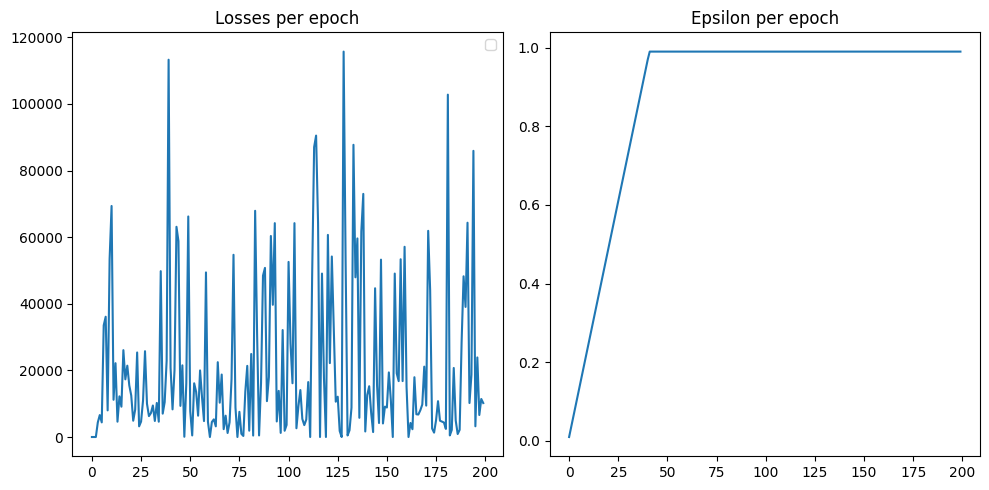

In [12]:
# Use the inline backend to display plots inline within the notebook
%matplotlib inline

# Create a figure
plt.figure(figsize=(10, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Losses per epoch')
# plt.axvline(color='r', linestyle='--', linewidth=1, label='start of training')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.title('Epsilon per epoch')

# Show the plots
plt.tight_layout()
plt.show()

C:\Users\amaur\AppData\Local\Temp\ipykernel_7016\1609246065.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


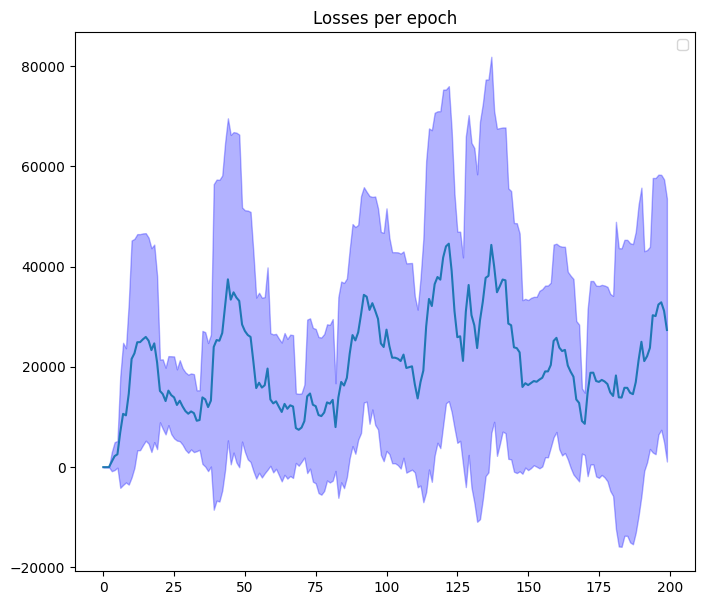

In [13]:
# Créer la figure
plt.figure(figsize=(8, 7))

# Calcul de la moyenne mobile des 10 dernières losses
mean_loss = [np.mean(losses[max(0, i-9):i+1]) for i in range(len(losses))]

# Calcul de l'écart type pour la zone ombrée
std_loss = [np.std(losses[max(0, i-9):i+1]) for i in range(len(losses))]

# Tracé de la courbe des pertes avec zone ombrée (intervalle de confiance)
# plt.plot(losses, label='Losses', color='blue')
plt.plot(mean_loss)
plt.fill_between(range(len(losses)), np.array(mean_loss) - np.array(std_loss), 
                 np.array(mean_loss) + np.array(std_loss), color='blue', alpha=0.3)

# Ajouter le titre et la légende
plt.title('Losses per epoch')
plt.legend()

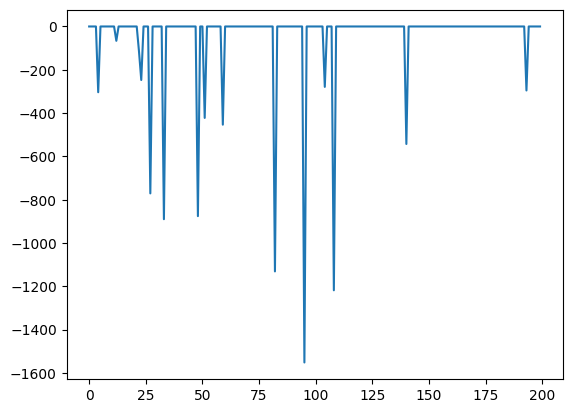

In [14]:
plt.plot(rewards)

C:\Users\amaur\AppData\Local\Temp\ipykernel_7016\3943545232.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


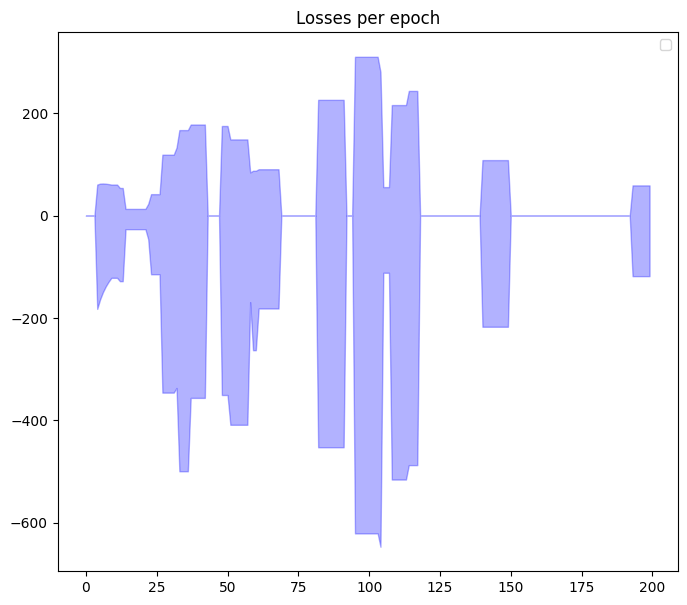

In [15]:
# Créer la figure
plt.figure(figsize=(8, 7))

# Calcul de la moyenne mobile des 10 dernières losses
mean_reward = [np.mean(rewards[max(0, i-9):i+1]) for i in range(len(rewards))]

# Calcul de l'écart type pour la zone ombrée
std_reward = [np.std(rewards[max(0, i-9):i+1]) for i in range(len(rewards))]

# Tracé de la courbe des pertes avec zone ombrée (intervalle de confiance)
# plt.plot(losses, label='Losses', color='blue')
plt.fill_between(range(len(rewards)), np.array(mean_reward) - np.array(std_reward), 
                 np.array(mean_reward) + np.array(std_reward), color='blue', alpha=0.3)

# Ajouter le titre et la légende
plt.title('Losses per epoch')
plt.legend()

### With Learning rate = 1e-4

In [4]:
learning_rate = 1e-4
dqn_mm = DQNMarketMaker(
    initial_cash,
    amount_to_trade,
    epsilon,
    epsilon_decay,
    epsilon_max,
    gamma,
    replay_memory_init,
    replay_memory_capacity,
    N_update,
    learning_rate,
    batch_size,
    activation_function,
    list_weights,
    input_dim = 7,
    output_dim=605
)

random_mm = RandomMarketMaker(initial_cash,amount_to_trade)

sim = Market(
    interval,
    num_trades,
    vol,
    random_mm,
    dqn_mm,
    num_noise_agents=100,
)

In [5]:
epochs = 200
spot = 100
spread = 3
losses = np.zeros(epochs)
epsilons = np.zeros(epochs)
rewards = np.zeros(epochs)
for epoch in tqdm(range(epochs)):
    epsilons[epoch] = dqn_mm.epsilon
    _, _, _, _, _, reward = sim.simulate(
        spot, spread, price_ticks, price_ticks, quantities, save_books=True
    )
    losses[epoch] = dqn_mm.train_online_network()
    rewards[epoch] = reward
    if epoch % N_update == 0:
        dqn_mm.update_target_network()

  0%|          | 1/200 [00:01<04:15,  1.28s/it]c:\Users\amaur\Documents\market_making_dqn\naive_order_book\market.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(o_i + pnl_i - hci, dtype=torch.double)
100%|██████████| 200/200 [04:13<00:00,  1.27s/it]


C:\Users\amaur\AppData\Local\Temp\ipykernel_7016\1516601315.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


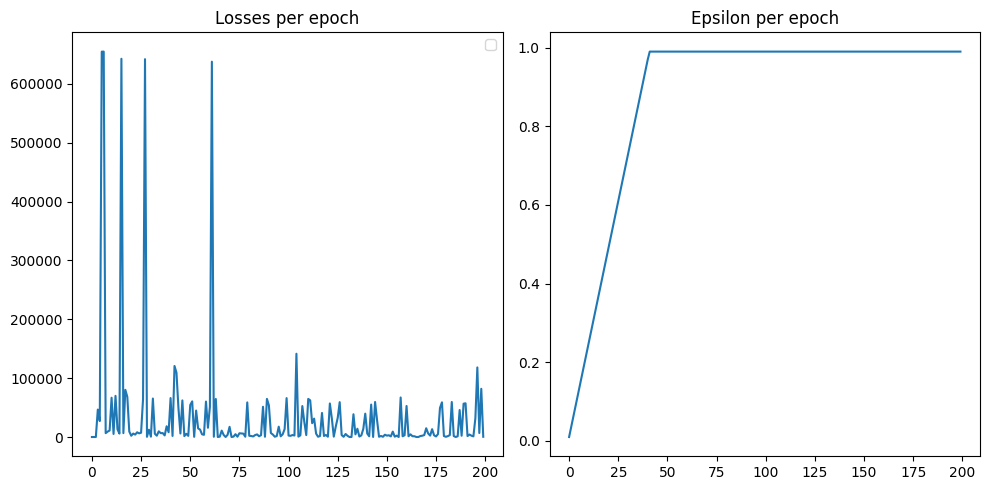

In [6]:
# Use the inline backend to display plots inline within the notebook
%matplotlib inline

# Create a figure
plt.figure(figsize=(10, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Losses per epoch')
# plt.axvline(color='r', linestyle='--', linewidth=1, label='start of training')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.title('Epsilon per epoch')

# Show the plots
plt.tight_layout()
plt.show()

C:\Users\amaur\AppData\Local\Temp\ipykernel_7016\1609246065.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


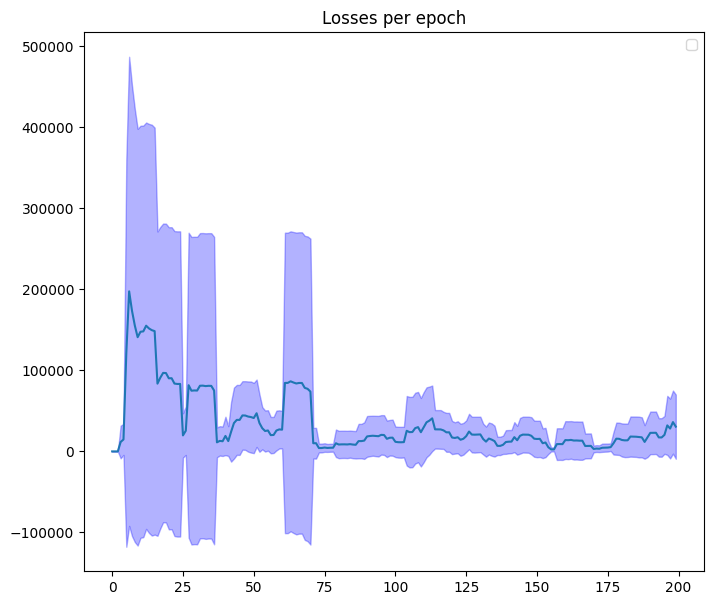

In [7]:
# Créer la figure
plt.figure(figsize=(8, 7))

# Calcul de la moyenne mobile des 10 dernières losses
mean_loss = [np.mean(losses[max(0, i-9):i+1]) for i in range(len(losses))]

# Calcul de l'écart type pour la zone ombrée
std_loss = [np.std(losses[max(0, i-9):i+1]) for i in range(len(losses))]

# Tracé de la courbe des pertes avec zone ombrée (intervalle de confiance)
# plt.plot(losses, label='Losses', color='blue')
plt.plot(mean_loss)
plt.fill_between(range(len(losses)), np.array(mean_loss) - np.array(std_loss), 
                 np.array(mean_loss) + np.array(std_loss), color='blue', alpha=0.3)

# Ajouter le titre et la légende
plt.title('Losses per epoch')
plt.legend()

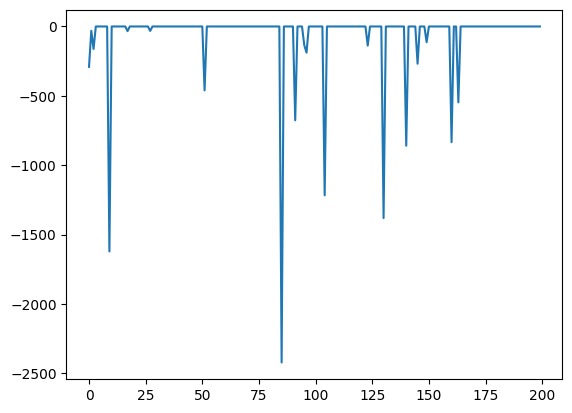

In [8]:
plt.plot(rewards)

C:\Users\amaur\AppData\Local\Temp\ipykernel_7016\3943545232.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


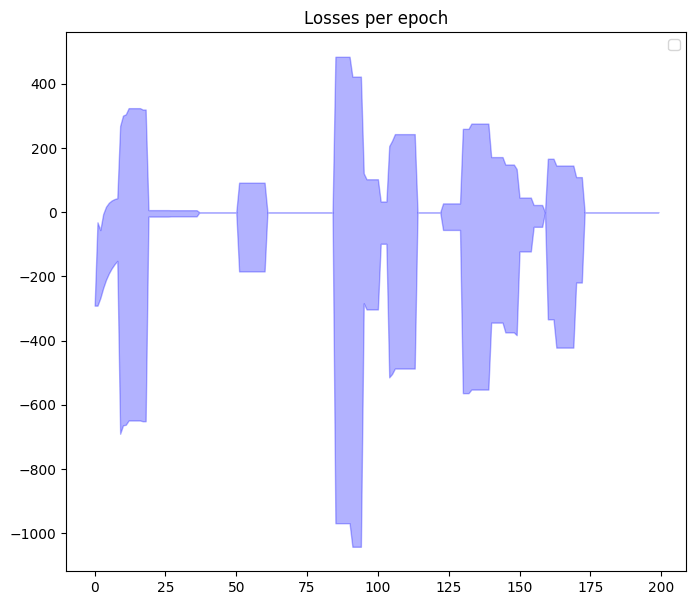

In [9]:
# Créer la figure
plt.figure(figsize=(8, 7))

# Calcul de la moyenne mobile des 10 dernières losses
mean_reward = [np.mean(rewards[max(0, i-9):i+1]) for i in range(len(rewards))]

# Calcul de l'écart type pour la zone ombrée
std_reward = [np.std(rewards[max(0, i-9):i+1]) for i in range(len(rewards))]

# Tracé de la courbe des pertes avec zone ombrée (intervalle de confiance)
# plt.plot(losses, label='Losses', color='blue')
plt.fill_between(range(len(rewards)), np.array(mean_reward) - np.array(std_reward), 
                 np.array(mean_reward) + np.array(std_reward), color='blue', alpha=0.3)

# Ajouter le titre et la légende
plt.title('Losses per epoch')
plt.legend()